# Manhattan Properties Sales Analysis

## Datasets:

1. [Rolling Sales](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)
2. [RPAD](https://www1.nyc.gov/site/finance/taxes/property-assessments.page) 
3. [PLUTO](http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page)

Every dataset contains borough-block-lot combination, each of which maps uniquely to an individual property. Dataset contains all types of properties(small homes(1,2,3 or more bedrooms townhomes and co-ops) or an apartment(condominiums). Assessment values and market values are present in the RPAD and Rolling Sales datasets, respectively. 

Currently unable to map information on apartment values. Complete Building Value is considered for now.

Dataset Information:
1. Rolling Sales contains the actual market prices of all buildings sold in New York City in the last twelve months. Market value from Rolling Sales data is our target variable. However, this dataset consist of lot of missing data.

2. RPAD is a record of the assessed value, as determined by the New York City Department of Finance for tax purposes. 

3. The PLUTO dataset provides conbination a large number of datasets published by various agencies in New York City as a single master record for categorical information on every property in New York City. It gives RPAD and Rolling Sales information a rich context.



In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import zipfile
import io
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

## Data Scrapping

### Rolling sales dataset

It is available in `xls` files (Excel):


In [3]:
rsd = dict()
rsd_key_pairs = {'Manhattan': 'manhattan'}
for b_k, b_xls in tqdm(list(rsd_key_pairs.items())):
    borough_rsd = pd.read_excel('https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_{0}.xls'.format(b_xls))
    borough_rsd.columns = borough_rsd.iloc[3].values
    borough_rsd = borough_rsd[4:]
    rsd[b_k] = borough_rsd

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.05s/it]


### PLUTO dataset

It is provided as borough-denominated `csv` files packaged into a `zip`. we will be using `Mn.csv` for Manhattan area data.

In [4]:
r = requests.get('http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v1.zip')
pluto_key_pairs = {'Manhattan': 'MN.csv'}
pluto_data = dict()
for b_k, b_csv in tqdm(list(pluto_key_pairs.items())):
    with zipfile.ZipFile(io.BytesIO(r.content)) as ar:
        borough_pluto = pd.read_csv(ar.open(b_csv))
        pluto_data[b_k] = borough_pluto

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Creating a `Borough` column newly in rolling_sales(previously (numerically encoded) `BOROUGH`) and PLUTO (previously (acronym-encoded)) dataset.

In [5]:
rsd_agglom = pd.DataFrame(columns=rsd['Manhattan'].columns)
pluto_data_agglom = pd.DataFrame(columns=pluto_data['Manhattan'].columns)
for b_k in tqdm(pluto_key_pairs.keys()):
    pluto_data[b_k]['Borough'] = rsd[b_k]['Borough'] = b_k
    rsd_agglom = pd.concat([rsd_agglom, rsd[b_k]], ignore_index=True)
    pluto_data_agglom = pd.concat([pluto_data_agglom, pluto_data[b_k]], ignore_index=True)
del rsd_agglom['BOROUGH']

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.00it/s]


### RPAD Dataset
RPAD is split into two files
1. properties in tax class 1 (single, double, and triple -family homes)
2. properties in tax classes 2/3/4 (everything else).

These are provided as compressed `zip` files containing `mdb` database files (for Microsoft Access).
Using Microsoft Access I export RPAD database files(`mdb`) to comma-delimited `txt` files. 

In [6]:
rpad_data_all = pd.concat([pd.read_csv("./data/tc1.txt"), pd.read_csv("./data/tc234.txt")], ignore_index=True)

In [7]:
# Seperating Manhattan data
rpad_data_mn=rpad_data_all[rpad_data_all['BORO']==1.0]
rpad_data_mn.head()

,BBLE,BORO,BLOCK,LOT,EASE,SECVOL,DISTRICT,YEAR4,CUR_FV_L,CUR_FV_T,NEW_FV_L,NEW_FV_T,FV_CHGDT,CURAVL,CURAVT,CUREXL,CUREXT,CURAVL_A,CURAVT_A,CUREXL_A,CUREXT_A,CHGDT,TN_AVL,TN_AVT,TN_EXL,TN_EXT,TN_AVL_A,TN_AVT_A,TN_EXL_A,TN_EXT_A,FCHGDT,FN_AVL,FN_AVT,FN_EXL,FN_EXT,FN_AVL_A,FN_AVT_A,FN_EXL_A,FN_EXT_A,TXCL,O_TXCL,CBN_TXCL,BLDGCL,EXMTCL,OWNER,HNUM_LO,HNUM_HI,STR_NAME,ZIP,TOT_UNIT,RES_UNIT,LFRT_DEC,LDEP_DEC,L_ACRE,IRREG,BFRT_DEC,BDEP_DEC,BLD_VAR,EXT,STORY,BLDGS,CORNER,LND_AREA,GR_SQFT,ZONING,YRB,YRB_FLAG,YRB_RNG,YRA1,YRA1_RNG,YRA2,YRA2_RNG,CP_BORO,CP_DIST,LIMIT,O_LIMIT,STATUS1,STATUS2,NEWLOT,DROPLOT,DELCHG,CORCHG,NODESC,NOAV,VALREF,MBLDG,CONDO_NM,CONDO_S1,CONDO_S2,CONDO_S3,CONDO_A,COMINT_L,COMINT_B,APTNO,AP_BORO,AP_BLOCK,AP_LOT,AP_EASE,AP_DATE,AP_TIME,PROTEST,AT_GRP,APPLIC,PROTEST2,AT_GRP2,APPLIC2,O_PROTST,O_AT_GRP,O_APPLIC,REUC,GEO_RC,COOP_NUM,EX_INDS,EX_COUNT,EX_CHGDT,DCHGDT,SM_CHGDT
0,1000750043,1.0,75.0,43.0,NaN,102.0,1,2016.0,5456000.0,6837000.0,5456000.0,9230000.0,12/08/2016,207764.0,260352.0,0.0,0.0,207764.0,260352.0,0.0,0.0,12/08/2016,163131.0,275972.0,0.0,0.0,163131.0,275972.0,0.0,0.0,00/00/0000,163131.0,275972.0,0.0,0.0,163131.0,275972.0,0.0,0.0,1,1,1,C0,NaN,"YUEN, SO SAN",000000000026,000000000026,CLIFF STREET,10038.0,3.0,3.0,19.42,89.33,NaN,I,20.00,80.0,NaN,NaN,4.0,1.0,NaN,1690.0,6400.0,C6-4,1974.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,NaN,0.0,00/00/0000,03/19/2009,12/08/2016
1,1000780040,1.0,78.0,40.0,NaN,102.0,1,2016.0,4620000.0,6015000.0,4620000.0,5999000.0,12/12/2016,199086.0,259200.0,0.0,0.0,199086.0,259200.0,0.0,0.0,12/12/2016,211594.0,274752.0,0.0,0.0,211594.0,274752.0,0.0,0.0,00/00/0000,211594.0,274752.0,0.0,0.0,211594.0,274752.0,0.0,0.0,1,1,1,S2,NaN,"H.B.S. EQUITIES,",000000000086,000000000086,NASSAU STREET,10038.0,3.0,2.0,16.58,51.75,NaN,I,19.00,52.0,NaN,NaN,5.0,1.0,NaN,854.0,4140.0,C5-5,1910.0,E,0.0,2004.0,0.0,2004.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,NaN,0.0,00/00/0000,03/22/2007,12/12/2016
2,1000970017,1.0,97.0,17.0,NaN,103.0,1,2016.0,2990000.0,5088000.0,2990000.0,6106000.0,12/12/2016,136680.0,232585.0,0.0,0.0,136680.0,232585.0,0.0,0.0,12/12/2016,120726.0,246540.0,0.0,0.0,120726.0,246540.0,0.0,0.0,00/00/0000,120726.0,246540.0,0.0,0.0,120726.0,246540.0,0.0,0.0,1,1,1,S1,NaN,"SPAEDA, DORATHEA S.",000000000211,000000000211,FRONT STREET,10038.0,2.0,1.0,25.00,39.83,NaN,I,25.00,40.0,NaN,NaN,5.0,1.0,NE,992.0,4960.0,C6-2A,1900.0,E,0.0,1981.0,0.0,2005.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,8,115.0,1.0,NaN,0.0,NaN,8,115.0,1.0,NaN,0,0.0,NaN,0.0,00/00/0000,03/21/2017,12/12/2016
3,1000970036,1.0,97.0,36.0,NaN,103.0,1,2016.0,3950000.0,6291000.0,3950000.0,7549000.0,12/12/2016,94325.0,150228.0,1550.0,1550.0,94325.0,150228.0,1550.0,1550.0,12/12/2016,78606.0,150228.0,1550.0,1550.0,78606.0,150228.0,1550.0,1550.0,05/19/2017,78606.0,150228.0,1470.0,1470.0,78606.0,150228.0,1470.0,1470.0,1,1,1,S2,NaN,"BARNET, ANDREA",000000000226,000000000226,FRONT STREET,10038.0,3.0,2.0,25.08,71.00,NaN,I,25.08,71.0,NaN,NaN,4.0,1.0,NaN,1775.0,6600.0,C6-2A,1901.0,E,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,EEEE,1.0,00/00/0000,03/26/2008,12/12/2016
4,1000970044,1.0,97.0,44.0,NaN,103.0,1,2016.0,1836000.0,2677000.0,1836000.0,3614000.0,12/08/2016,40531.0,59097.0,0.0,0.0,40531.0,59097.0,0.0,0.0,12/08/2016,30023.0,59097.0,0.0,0.0,30023.0,59097.0,0.0,0.0,00/00/0000,30023.0,59097.0,0.0,0.0,30023.0,59097.0,0.0,0.0,1,1,1,A9,NaN,"136 BEEKMAN, LLC",000000000136,000000000138,BEEKMAN STREET,10038.0,1.0,1.0,18.69,25.58,NaN,I,18.60,25.5,NaN,NaN,4.0,1.0,NaN,477.0,1900.0,C6-2A,1998.0,NaN,1999.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,

# Merge all 3 datasets

An outer join on the `(Borough, Block, Lot)` unique key (info provided at [lookup](http://www1.nyc.gov/nyc-resources/service/1232/borough-block-lot-bbl-lookup).

For the join, column names in the rolling sales dataset need to change from `SPACED ALL CAPS` to `NoSpaceCamelCase` (as used by `PLUTO`).

In [8]:
rsd_agglom.columns = [c.title().replace(' ', '') for c in list(rsd_agglom.columns)]
print(rsd_agglom.head())

                 Address ApartmentNumber Block BuildingClassAtPresent  \
0  264 EAST 7TH   STREET                   376                     C0   
1    738 EAST 6TH STREET                   375                     C4   
2           151 AVENUE B                   392                     C2   
3           153 AVENUE B                   392                     C2   
4  234 EAST 4TH   STREET                   399                     C7   

  BuildingClassAtTimeOfSale                        BuildingClassCategory  \
0                        C0  03 THREE FAMILY DWELLINGS                     
1                        C4  07 RENTALS - WALKUP APARTMENTS                
2                        C2  07 RENTALS - WALKUP APARTMENTS                
3                        C2  07 RENTALS - WALKUP APARTMENTS                
4                        C7  07 RENTALS - WALKUP APARTMENTS                

     Borough CommercialUnits Ease-Ment GrossSquareFeet LandSquareFeet Lot  \
0  Manhattan               

**Note** : A large number of records are of what are effectively deed transfers: sales of a building for either `$0` or `some nominal value`. As they lack in providing any actual sale information they should be dropped.

`$500` is arbitrarily chosen as a cutoff value.

In [9]:
rsd_agglom = rsd_agglom[rsd_agglom['SalePrice'] > 500].reindex()

The Rolling Sales dataset contains information on the sale of both individual apartments and of whole buildings, but does not contain the square footage of the apartment sales in the data. Since we need this for calculating standardized value per square foot, we have to throw out apartments entirely, unfortunately, from the dataset.

To do this we remove entries with no defined `LandSquareFeet` (no apartments have this value in any of the datasets, weirdly enough) and restrict apartment number from having `' '`, as in, space.

In [10]:
rs_a_f = rsd_agglom[rsd_agglom['ApartmentNumber'] ==' ']
rs_a_f = rs_a_f[rs_a_f['LandSquareFeet'] > 0]
rs_a_f.head()

,Address,ApartmentNumber,Block,BuildingClassAtPresent,BuildingClassAtTimeOfSale,BuildingClassCategory,Borough,CommercialUnits,Ease-Ment,GrossSquareFeet,LandSquareFeet,Lot,Neighborhood,ResidentialUnits,SaleDate,SalePrice,TaxClassAtPresent,TaxClassAtTimeOfSale,TotalUnits,YearBuilt,ZipCode
0,264 EAST 7TH STREET,,376,C0,C0,03 THREE FAMILY DWELLINGS,Manhattan,0,,3696,2059,24,ALPHABET CITY,3,2016-12-22 00:00:00,7738700,1,1,3,1900,10009
1,738 EAST 6TH STREET,,375,C4,C4,07 RENTALS - WALKUP APARTMENTS,Manhattan,0,,6500,1750,28,ALPHABET CITY,11,2017-04-03 00:00:00,3750000,2,2,11,1900,10009
3,153 AVENUE B,,392,C2,C2,07 RENTALS - WALKUP APARTMENTS,Manhattan,0,,6440,1633,6,ALPHABET CITY,5,2017-07-19 00:00:00,6625000,2A,2,5,1900,10009
6,197 EAST 3RD STREET,,399,C7,C7,07 RENTALS - WALKUP APARTMENTS,Manhattan,1,,7803,2212,39,ALPHABET CITY,16,2016-08-04 00:00:00,6300000,2,2,17,1900,10009
7,154 EAST 7TH STREET,,402,C4,C4,07 RENTALS - WALKUP APARTMENTS,Manhattan,0,,6794,2272,21,ALPHABET CITY,10,2016-09-23 00:00:00,3936272,2B,2,10,1913,10009


The unique combination of `Borough`-`Block`-`Lot` columns present in both PLUTO and the Rolling sales was supposed to be the key for join. However, this assumption turns out to be incorrect for following reasons.

The PLUTO dataset contains information on the square footage of entire buildings, but not on that of individual units. The Rolling Sales dataset contains sales information on individual apartments which, as a consequence of this tweak, cannot be mapped to any of the records in PLUTO.

Rolling Sales breaks the uniqueness by allowing the sale of sub-units within a single property block. This is really disorienting.

To resolve the issue, `Rolling Sales` contains both the `SalePrice` and the square footage of the property sold. Instead of working with `SalePrice` directly, we will compute an average `MarketValueSqFt` based on the sum of the `SalePrice` fields divided by the sum of the `BldgArea` fields for each unique `Borough`-`Block`-`Lot` combination in the dataset.

In [11]:
# Aggregate by Borough-Block-Lot
# Merge the non-key variables via summation, converting the groupby object to the hierarchical DataFrame.
rs_a_ff = rs_a_f[['Borough', 'Block', 'Lot','SalePrice', 'LandSquareFeet']].groupby(by=['Borough', 'Block', 'Lot']).sum().reset_index()
# create a new column for market value
rs_a_ff['MarketValueSqFt'] = rs_a_ff['SalePrice'] / rs_a_ff['LandSquareFeet']

#### JOIN

In [12]:
rsd_pluto = pd.merge(rs_a_ff, pluto_data_agglom,how='outer', on=['Borough', 'Block', 'Lot'])

#### Merge the RPAD dataset with the above. 
RPAD has a numerical borough column. So, explicitly mapping the `BORO` to a name value.

In [13]:
rpad_key_pairs = {1.0: 'Manhattan'}
rpad_data_mn['Borough'] = rpad_data_mn['BORO'].apply(lambda n: rpad_key_pairs[n])
del rpad_data_mn['BORO']

Converting columns from `ALL_CAPS_SPACERS` to `CamelCase`.

In [14]:
rpad_data_mn.columns = [c.title().replace('_', '') for c in list(rpad_data_mn.columns)]

In [15]:
rpad_data_mn.head(5)

,Bble,Block,Lot,Ease,Secvol,District,Year4,CurFvL,CurFvT,NewFvL,NewFvT,FvChgdt,Curavl,Curavt,Curexl,Curext,CuravlA,CuravtA,CurexlA,CurextA,Chgdt,TnAvl,TnAvt,TnExl,TnExt,TnAvlA,TnAvtA,TnExlA,TnExtA,Fchgdt,FnAvl,FnAvt,FnExl,FnExt,FnAvlA,FnAvtA,FnExlA,FnExtA,Txcl,OTxcl,CbnTxcl,Bldgcl,Exmtcl,Owner,HnumLo,HnumHi,StrName,Zip,TotUnit,ResUnit,LfrtDec,LdepDec,LAcre,Irreg,BfrtDec,BdepDec,BldVar,Ext,Story,Bldgs,Corner,LndArea,GrSqft,Zoning,Yrb,YrbFlag,YrbRng,Yra1,Yra1Rng,Yra2,Yra2Rng,CpBoro,CpDist,Limit,OLimit,Status1,Status2,Newlot,Droplot,Delchg,Corchg,Nodesc,Noav,Valref,Mbldg,CondoNm,CondoS1,CondoS2,CondoS3,CondoA,ComintL,ComintB,Aptno,ApBoro,ApBlock,ApLot,ApEase,ApDate,ApTime,Protest,AtGrp,Applic,Protest2,AtGrp2,Applic2,OProtst,OAtGrp,OApplic,Reuc,GeoRc,CoopNum,ExInds,ExCount,ExChgdt,Dchgdt,SmChgdt,Borough
0,1000750043,75.0,43.0,NaN,102.0,1,2016.0,5456000.0,6837000.0,5456000.0,9230000.0,12/08/2016,207764.0,260352.0,0.0,0.0,207764.0,260352.0,0.0,0.0,12/08/2016,163131.0,275972.0,0.0,0.0,163131.0,275972.0,0.0,0.0,00/00/0000,163131.0,275972.0,0.0,0.0,163131.0,275972.0,0.0,0.0,1,1,1,C0,NaN,"YUEN, SO SAN",000000000026,000000000026,CLIFF STREET,10038.0,3.0,3.0,19.42,89.33,NaN,I,20.00,80.0,NaN,NaN,4.0,1.0,NaN,1690.0,6400.0,C6-4,1974.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,NaN,0.0,00/00/0000,03/19/2009,12/08/2016,Manhattan
1,1000780040,78.0,40.0,NaN,102.0,1,2016.0,4620000.0,6015000.0,4620000.0,5999000.0,12/12/2016,199086.0,259200.0,0.0,0.0,199086.0,259200.0,0.0,0.0,12/12/2016,211594.0,274752.0,0.0,0.0,211594.0,274752.0,0.0,0.0,00/00/0000,211594.0,274752.0,0.0,0.0,211594.0,274752.0,0.0,0.0,1,1,1,S2,NaN,"H.B.S. EQUITIES,",000000000086,000000000086,NASSAU STREET,10038.0,3.0,2.0,16.58,51.75,NaN,I,19.00,52.0,NaN,NaN,5.0,1.0,NaN,854.0,4140.0,C5-5,1910.0,E,0.0,2004.0,0.0,2004.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,NaN,0.0,00/00/0000,03/22/2007,12/12/2016,Manhattan
2,1000970017,97.0,17.0,NaN,103.0,1,2016.0,2990000.0,5088000.0,2990000.0,6106000.0,12/12/2016,136680.0,232585.0,0.0,0.0,136680.0,232585.0,0.0,0.0,12/12/2016,120726.0,246540.0,0.0,0.0,120726.0,246540.0,0.0,0.0,00/00/0000,120726.0,246540.0,0.0,0.0,120726.0,246540.0,0.0,0.0,1,1,1,S1,NaN,"SPAEDA, DORATHEA S.",000000000211,000000000211,FRONT STREET,10038.0,2.0,1.0,25.00,39.83,NaN,I,25.00,40.0,NaN,NaN,5.0,1.0,NE,992.0,4960.0,C6-2A,1900.0,E,0.0,1981.0,0.0,2005.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,8,115.0,1.0,NaN,0.0,NaN,8,115.0,1.0,NaN,0,0.0,NaN,0.0,00/00/0000,03/21/2017,12/12/2016,Manhattan
3,1000970036,97.0,36.0,NaN,103.0,1,2016.0,3950000.0,6291000.0,3950000.0,7549000.0,12/12/2016,94325.0,150228.0,1550.0,1550.0,94325.0,150228.0,1550.0,1550.0,12/12/2016,78606.0,150228.0,1550.0,1550.0,78606.0,150228.0,1550.0,1550.0,05/19/2017,78606.0,150228.0,1470.0,1470.0,78606.0,150228.0,1470.0,1470.0,1,1,1,S2,NaN,"BARNET, ANDREA",000000000226,000000000226,FRONT STREET,10038.0,3.0,2.0,25.08,71.00,NaN,I,25.08,71.0,NaN,NaN,4.0,1.0,NaN,1775.0,6600.0,C6-2A,1901.0,E,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,EEEE,1.0,00/00/0000,03/26/2008,12/12/2016,Manhattan
4,1000970044,97.0,44.0,NaN,103.0,1,2016.0,1836000.0,2677000.0,1836000.0,3614000.0,12/08/2016,40531.0,59097.0,0.0,0.0,40531.0,59097.0,0.0,0.0,12/08/2016,30023.0,59097.0,0.0,0.0,30023.0,59097.0,0.0,0.0,00/00/0000,30023.0,59097.0,0.0,0.0,30023.0,59097.0,0.0,0.0,1,1,1,A9,NaN,"136 BEEKMAN, LLC",000000000136,000000000138,BEEKMAN STREET,10038.0,1.0,1.0,18.69,25.58,NaN,I,18.60,25.5,NaN,NaN,4.0,1.0,NaN,477.0,1900.0,C6-2A,1998.0,NaN,1999.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,9

The variables of interest in RPAD are:

* Borough (merge key).
* Block (merge key).
* Lot (merge key).
* CurFvT &mdash; Current market value, total. This is the Finance office's best guess as to the value of this property.
* NewFvT &mdash; New market value, total, [Note that the Finance office lags, by its own admission, generally a cycle or two behind the movements of the real estate market].
* CuravtA &mdash; current assessed value, total, determined by the city. Assessed value is computed using a complex and obtruse formulaic determination of rental market value. The very similar `Curavt` is a similar statistics which is rebalanced to increase no more than `20%` a year, per tax laws ([source](https://www1.nyc.gov/site/finance/taxes/property-determining-your-transitional-assessed-value.page)); it is excluded because `CuravtA` is, therefore, better correlated with actual value. `Curavt`, not market value, is what is used by the city to assess residential tax.

In [16]:
rpad_columns_of_interest = ['Borough', 'Block', 'Lot', 'CurFvT', 'NewFvT', 'CuravtA']
counts = rpad_data_mn.groupby(by=['Borough', 'Block', 'Lot']).count().reset_index()
counts = counts.sort_values(by='CurFvT', ascending=False)
counts[counts['Bble'] > 1]

,Borough,Block,Lot,Bble,Ease,Secvol,District,Year4,CurFvL,CurFvT,NewFvL,NewFvT,FvChgdt,Curavl,Curavt,Curexl,Curext,CuravlA,CuravtA,CurexlA,CurextA,Chgdt,TnAvl,TnAvt,TnExl,TnExt,TnAvlA,TnAvtA,TnExlA,TnExtA,Fchgdt,FnAvl,FnAvt,FnExl,FnExt,FnAvlA,FnAvtA,FnExlA,FnExtA,Txcl,OTxcl,CbnTxcl,Bldgcl,Exmtcl,Owner,HnumLo,HnumHi,StrName,Zip,TotUnit,ResUnit,LfrtDec,LdepDec,LAcre,Irreg,BfrtDec,BdepDec,BldVar,Ext,Story,Bldgs,Corner,LndArea,GrSqft,Zoning,Yrb,YrbFlag,YrbRng,Yra1,Yra1Rng,Yra2,Yra2Rng,CpBoro,CpDist,Limit,OLimit,Status1,Status2,Newlot,Droplot,Delchg,Corchg,Nodesc,Noav,Valref,Mbldg,CondoNm,CondoS1,CondoS2,CondoS3,CondoA,ComintL,ComintB,Aptno,ApBoro,ApBlock,ApLot,ApEase,ApDate,ApTime,Protest,AtGrp,Applic,Protest2,AtGrp2,Applic2,OProtst,OAtGrp,OApplic,Reuc,GeoRc,CoopNum,ExInds,ExCount,ExChgdt,Dchgdt,SmChgdt
138597,Manhattan,1775.0,6.0,5,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,0,4,2,2,3,5,5,5,5,5,3,0,5,5,0,0,5,5,1,5,5,5,5,0,5,5,5,5,5,5,5,0,0,5,5,5,5,5,5,5,5,5,5,5,0,0,0,0,5,5,0,5,5,5,3,5,5,0,5,0,0,5,0,1,5,1,1,5,5,2,5,5,5,5
37752,Manhattan,665.0,10.0,5,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,5,0,0,5,5,5,5,5,5,0,1,5,5,0,0,5,5,0,5,5,5,5,1,5,5,5,5,5,5,5,0,0,5,5,5,5,5,5,5,5,5,5,5,0,0,0,0,5,5,0,5,5,5,0,5,5,0,5,0,0,5,0,0,5,0,0,5,5,1,5,5,5,5
61450,Manhattan,962.0,8.0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,0,5,0,0,5,5,5,5,5,5,0,0,5,5,0,0,5,5,0,5,5,5,5,0,5,5,5,5,5,5,5,0,0,5,5,5,5,5,5,5,5,5,5,5,0,0,0,0,5,5,0,5,5,5,0,5,5,0,5,0,0,5,0,0,5,0,5,5,5,0,5,5,5,5
37784,Manhattan,680.0,1.0,5,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,0,1,1,1,1,5,5,5,5,5,0,1,5,5,0,0,5,5,0,5,5,5,5,0,5,5,5,5,5,5,5,0,0,5,5,5,5,5,5,5,5,5,5,5,0,0,0,0,5,5,0,5,5,5,0,5,5,0,5,0,0,5,0,0,5,0,4,5,5,1,5,5,5,5
158385,Manhattan,2178.0,1.0,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,4,0,0,4,4,4,4,4,4,0,1,4,4,0,0,4,4,0,4,4,4,4,0,4,4,4,4,4,4,4,0,0,4,4,4,4,4,4,4,4,4,4,4,0,0,0,0,4,4,0,4,4,4,0,4,4,0,4,0,0,4,0,0,4,0,1,4,4,1,4,4,4,4
37781,Manhattan,676.0,3.0,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,3,0,0,3,4,4,4,4,4,0,1,4,4,0,0,4,4,1,4,4,4,4,0,4,4,4,4,4,4,4,0,0,4,4,4,4,4,4,4,4,4,4,4,0,0,0,0,4,4,0,4,4,4,0,4,4,0,4,0,0,4,0,0,4,0,4,4,4,0,4,4,4,4
158457,Manhattan,2179.0,625.0,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,4,1,1,4,4,4,4,4,4,0,1,4,4,0,0,4,4,0,4,4,4,4,1,4,4,4,4,4,4,4,0,0,4,4,4,4,4,4,4,4,4,4,4,0,0,0,0,4,4,0,4,4,4,0,4,4,0,4,0,0,4,0,0,4,0,1,4,4,1,4,4,4,4
96933,Manhattan,1280.0,30.0,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,4,1,1,4,4,4,4,4,4,0,0,4,4,0,0,4,4,1,4,4,4,4,0,4,4,4,4,4,3,3,0,0,4,4,4,4,4,4,4,4,4,4,4,0,0,0,0,4,4,0,4,4,4,0,4,4,1,4,1,0,4,0,1,4,1,3,4,4,1,4,4,4,4
62482,Manhattan,970.0,1.0,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,1,1,4,4,4,4,4,4,0,1,4,4,0,0,4,4,1,4,4,4,4,0,4,4,4,4,4,4,4,0,0,4,4,4,4,4,4,4,4,4,4,4,0,0,0,0,4,4,0,4,4,4,0,4,4,1,4,1,0,4,0,1,4,1,4,4,4,0,4,4,4,4
96932,Manhattan,1280.0,10.0,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,0,0,4,4,4,4,4,4,0,0,4,4,0,0,4,4,1,4,4,4,4,0,4,4,4,4,4,4,4,0,0,4,4,4,4,4,4,4,4,4,4,4,0,0,0,0,4,4,0,4,4,4,0,4,4,0,4,0,0,4,0,0,4,0,2,4,4,0,4,4,4,4


Regrouping the `RPAD` data according to `Borough`-`Block`-`Lot` schema reveals that `Borough`-`Block`-`Lot` *still* wasn't unique somewhere.

In [17]:
rpad_data_mn.groupby(by=['Borough', 'Block', 'Lot']).count()

Bble  Ease  Secvol  District  Year4  CurFvL  CurFvT  \
Borough   Block  Lot                                                           
Manhattan 1.0    10.0       1     0       1         1      1       1       1   
                 101.0      1     0       1         1      1       1       1   
                 201.0      1     0       1         1      1       1       1   
                 301.0      1     0       1         1      1       1       1   
                 401.0      1     0       1         1      1       1       1   
          2.0    1.0        1     0       1         1      1       1       1   
                 2.0        1     0       1         1      1       1       1   
                 3.0        1     0       1         1      1       1       1   
                 23.0       1     0       1         1      1       1       1   
          3.0    1.0        1     0       1         1      1       1       1   
...                       ...   ...     ...       ...    ...     ...     ...   
          2250.0 72.0       1     0       1         1      1       1       1   
                 75.0       1     0       1         1      1       1       1   
                 78.0       1     0       1         1      1       1       1   
                 80.0       1     0       1         1      1       1       1   
                 84.0       1     0       1         1      1       1       1   
                 86.0       1     0       1         1      1       1       1   
                 158.0      1     0       1         1      1       1       1   
          2255.0 1.0        1     0       1         1      1       1       1   
                 1031.0     2     1       2         2      2       2       2   
                 2000.0     2     1       2         2      2       2       2   

                         NewFvL  NewFvT  FvChgdt  Curavl  Curavt  Curexl  \
Borough   Block  Lot                                                       
Manhattan 1.0    10.0         1       1        1       1       1       1   
                 101.0        1       1        1       1       1       1   
                 201.0        1       1        1       1       1       1   
                 301.0        1       1        1       1       1       1   
                 401.0        1       1        1       1       1       1   
          2.0    1.0          1       1        1       1       1       1   
                 2.0          1       1        1       1       1       1   
                 3.0          1       1        1       1       1       1   
                 23.0         1       1        1       1       1       1   
          3.0    1.0          1       1        1       1       1       1   
...                         ...     ...      ...     ...     ...     ...   
          2250.0 72.0         1       1        1       1       1       1   
                 75.0         1       1        1       1       1       1   
                 78.0         1       1        1       1       1       1   
                 80.0         1       1        1       1       1       1   
                 84.0         1       1        1       1       1       1   
                 86.0         1       1        1       1       1       1   
                 158.0        1       1        1       1       1       1   
          2255.0 1.0          1       1        1       1       1       1   
                 1031.0       2       2        2       2       2       2   
                 2000.0       2       2        2       2       2       2   

                         Curext  CuravlA  CuravtA  CurexlA  CurextA  Chgdt  \
Borough   Block  Lot                                                         
Manhattan 1.0    10.0         1        1        1        1        1      1   
                 101.0        1        1        1        1        1      1   
                 201.0        1        1        1        1        1      1   
                 301.0        1        1     

Zooming in on one of the cases shows why&mdash;easements are all listed seperately within the file!

In [18]:
rpad_data_mn[(rpad_data_mn['Borough'] == 'Manhattan') &
                 (rpad_data_mn['Block'] == 665.0) &
                 (rpad_data_mn['Lot'] == 10.0)]

,Bble,Block,Lot,Ease,Secvol,District,Year4,CurFvL,CurFvT,NewFvL,NewFvT,FvChgdt,Curavl,Curavt,Curexl,Curext,CuravlA,CuravtA,CurexlA,CurextA,Chgdt,TnAvl,TnAvt,TnExl,TnExt,TnAvlA,TnAvtA,TnExlA,TnExtA,Fchgdt,FnAvl,FnAvt,FnExl,FnExt,FnAvlA,FnAvtA,FnExlA,FnExtA,Txcl,OTxcl,CbnTxcl,Bldgcl,Exmtcl,Owner,HnumLo,HnumHi,StrName,Zip,TotUnit,ResUnit,LfrtDec,LdepDec,LAcre,Irreg,BfrtDec,BdepDec,BldVar,Ext,Story,Bldgs,Corner,LndArea,GrSqft,Zoning,Yrb,YrbFlag,YrbRng,Yra1,Yra1Rng,Yra2,Yra2Rng,CpBoro,CpDist,Limit,OLimit,Status1,Status2,Newlot,Droplot,Delchg,Corchg,Nodesc,Noav,Valref,Mbldg,CondoNm,CondoS1,CondoS2,CondoS3,CondoA,ComintL,ComintB,Aptno,ApBoro,ApBlock,ApLot,ApEase,ApDate,ApTime,Protest,AtGrp,Applic,Protest2,AtGrp2,Applic2,OProtst,OAtGrp,OApplic,Reuc,GeoRc,CoopNum,ExInds,ExCount,ExChgdt,Dchgdt,SmChgdt,Borough
745148,1006650010,665.0,10.0,NaN,301.0,8,2016.0,15800000.0,55415000.0,15800000.0,57077000.0,12/27/2016,7236360.0,23413770.0,7236360.0,23413770.0,7110000.0,24936750.0,7110000.0,24936750.0,12/27/2016,7110000.0,24212340.0,7110000.0,24212340.0,7110000.0,25684650.0,7110000.0,25684650.0,00/00/0000,7110000.0,24212340.0,7110000.0,24212340.0,7110000.0,25684650.0,7110000.0,25684650.0,4,4,4,T2,X1,NYC DSBS,NaN,NaN,MARGINAL STREET,0.0,1.0,0.0,738.08,734.0,NaN,I,637.0,615.0,NaN,NaN,1.0,1.0,NaN,588000.0,393040.0,M2-3,1900.0,E,0.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,NaN,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,12,0.0,EEEE,1.0,00/00/0000,12/30/1993,12/27/2016,Manhattan
745149,1006650010E,665.0,10.0,E,301.0,91,2016.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3,U1,NaN,OWNER / AGENT,NaN,NaN,12 AVENUE,0.0,0.0,0.0,0.00,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,M2-3,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,NaN,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,12,0.0,NaN,0.0,00/00/0000,11/18/2010,00/00/0000,Manhattan
745150,1006650010F,665.0,10.0,F,301.0,91,2016.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3,U1,NaN,OWNER / AGENT,NaN,NaN,12 AVENUE,0.0,0.0,0.0,0.00,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,M2-3,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,NaN,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,12,0.0,NaN,0.0,00/00/0000,11/18/2010,00/00/0000,Manhattan
745151,1006650010G,665.0,10.0,G,301.0,91,2016.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3,U1,NaN,OWNER / AGENT,NaN,NaN,12 AVENUE,0.0,0.0,0.0,0.00,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,M2-3,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,NaN,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,12,0.0,NaN,0.0,00/00/0000,11/18/2010,00/00/0000,Manhattan
745152,1006650010H,665.0,10.0,H,301.0,91,2016.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00/00/0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3,U1,NaN,OWNER / AGENT,NaN,NaN,12 AVENUE,0.0,0.0,0.0,0.00,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,M2-3,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,NaN,1,0,0,0,0,0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,00/00/0000,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,12,0.0,NaN,0.0,00/00/0000,11/18/2010,00/00/0000,Manhattan


Easements indicate encumerances on the property by others&mdash;usually the city subway tracks.
Easements have no property value, so we can simply remove the entries corresponding to them.

In [19]:
rpad_data_mn_f = rpad_data_mn[rpad_data_mn['Ease'].isnull()]

## Final Merge

In [20]:
rsd_pluto_rpad = pd.merge(rsd_pluto, rpad_data_mn_f[rpad_columns_of_interest],how='inner', on=['Borough', 'Block', 'Lot'])

In [21]:
# Records drop percentage
abs((len(rsd_pluto_rpad) - len(rsd_pluto)) / len(rsd_pluto_rpad))*100

0.6295026928726306

### Cleaning master dataset

`BldgArea`,`Address` are important variable but quite a few records are missing it.
records missing an `Address`&mdash are usually malformed records or records of places belonging to the city or to the state.

In [22]:
rsd_pluto_rpad['BldgArea'].value_counts()[0.0]

2300

In [23]:
rsd_pluto_rpad = rsd_pluto_rpad[rsd_pluto_rpad['BldgArea'] > 0]
rsd_pluto_rpad = rsd_pluto_rpad[rsd_pluto_rpad['Address'].notnull()]

In [24]:
# Resolving issue with Column data types.
def convert_floats_and_whitespace_strings_to_floats_and_strings(series):
    l = []
    for entry in [str(entry).strip() for entry in series]:
        if entry == "":
            l.append(np.nan)
        else:
            try:
                l.append(float(entry))
            except ValueError:
                l.append(entry)
    return l

columns_needing_fixing = rsd_pluto_rpad.columns
for column in columns_needing_fixing:
    rsd_pluto_rpad[column] = convert_floats_and_whitespace_strings_to_floats_and_strings(rsd_pluto_rpad[column])

rsd_pluto_rpad.head()

,Borough,Block,Lot,SalePrice,LandSquareFeet,MarketValueSqFt,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,LtdHeight,AllZoning1,AllZoning2,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,BuiltCode,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,CurFvT,NewFvT,CuravtA
0,Manhattan,10.0,33.0,100107200.0,6834.0,14648.405034,101.0,9.0,1026.0,2.0,1.0,10004.0,L015,1.0,7700.0,1.0,1.0,NaN,8 STONE STREET,C5-5,NaN,NaN,NaN,NaN,NaN,LM,NaN,NaN,C5-5/LM,NaN,N,H2,5.0,0.0,NaN,LEX STONE STREET L.P.,6834.0,143730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,43.0,0.0,1.0,71.50,125.00,71.12,125.00,NaN,0.0,Y,4.0,2.0,3690450.0,37567800.0,0.0,0.0,2007.0,NaN,0.0,0.0,NaN,NaN,21.03,10.0,15.0,15.0,1.0,1.000100e+09,0.0,9.0,980840.0,195705.0,12b,NaN,101S001,10101.0,NaN,0.000000e+00,NaN,1.0,16v1,83484000.0,79236000.0,37567800.0
1,Manhattan,27.0,9.0,239114603.0,17623.0,13568.325654,101.0,7.0,1020.0,2.0,1.0,10005.0,L015,1.0,7700.0,1.0,1.0,1B,63 WALL STREET,C5-5,NaN,NaN,NaN,NaN,NaN,LM,NaN,NaN,C5-5/LM,NaN,N,D5,3.0,0.0,P,RBNB WALL STREET OWNE,17623.0,400531.0,22000.0,378531.0,0.0,12000.0,10000.0,0.0,0.0,0.0,2.0,1.0,37.0,476.0,482.0,112.50,213.17,112.50,213.17,NaN,0.0,Y,3.0,2.0,11880000.0,41176350.0,0.0,5711400.0,1929.0,NaN,2004.0,0.0,NaN,NaN,22.73,10.0,15.0,15.0,1.0,1.000270e+09,0.0,7.0,981817.0,196356.0,12b,NaN,101S006,10101.0,NaN,0.000000e+00,NaN,1.0,16v1,91503000.0,100465000.0,41176350.0
2,Manhattan,27.0,17.0,182391612.0,12127.0,15040.126330,101.0,7.0,1020.0,2.0,1.0,10005.0,L015,1.0,7700.0,1.0,1.0,1B,67 WALL STREET,C5-5,NaN,NaN,NaN,NaN,NaN,LM,NaN,NaN,C5-5/LM,NaN,N,D5,3.0,0.0,NaN,RBNB 67 WALL STREET O,12127.0,303175.0,38772.0,264403.0,22550.0,10222.0,0.0,6000.0,0.0,0.0,2.0,1.0,25.0,317.0,323.0,144.00,145.00,143.00,140.00,NaN,2.0,Y,3.0,2.0,7200000.0,35282250.0,0.0,10960374.0,1921.0,NaN,2006.0,0.0,NaN,NaN,25.00,10.0,15.0,15.0,1.0,1.000270e+09,0.0,7.0,981921.0,196326.0,12b,NaN,101S006,10101.0,NaN,0.000000e+00,NaN,1.0,16v1,78405000.0,78394000.0,35282250.0
3,Manhattan,29.0,1.0,652000000.0,42762.0,15247.182077,101.0,9.0,1010.0,2.0,1.0,10004.0,L015,1.0,7700.0,1.0,1.0,NaN,91 BROAD STREET,C5-5,NaN,NaN,NaN,NaN,NaN,LM,NaN,NaN,C5-5/LM,NaN,N,O4,5.0,0.0,NaN,85 BROAD PROPCO LLC,42762.0,993569.0,993569.0,0.0,993569.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,31.0,0.0,1.0,232.00,290.00,115.00,246.00,NaN,0.0,Y,3.0,5.0,40500000.0,85676850.0,0.0,0.0,1983.0,NaN,0.0,0.0,NaN,NaN,23.23,10.0,15.0,15.0,1.0,1.000290e+09,0.0,9.0,981185.0,195760.0,12b,NaN,101S002,10101.0,NaN,1.000290e+09,10/15/2008,1.0,16v1,190393000.0,194228000.0,85676850.0
4,Manhattan,38.0,17.0,3288000.0,27600.0,119.130435,101.0,7.0,1012.0,2.0,1.0,10005.0,E004,1.0,7700.0,1.0,1.0,NaN,88 PINE STREET,C6-9,NaN,NaN,NaN,NaN,NaN,LM,NaN,NaN,C6-9/LM,NaN,N,O4,5.0,0.0,P,ORIENT OVERSEAS ASSOC,27600.0,566858.0,566858.0,0.0,566858.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,32.0,0.0,23.0,251.33,114.33,211.00,93.00,NaN,1.0,Y,3.0,2.0,16200000.0,59902200.0,0.0,0.0,1973.0,NaN,2007.0,0.0,NaN,NaN,20.54,10.0,15.0,15.0,1.0,1.000380e+09,0.0,7.0,982540.0,196368.0,12b,NaN,101S007,10101.0,NaN,0.000000e+00,NaN,1.0,16v1,133116000.0,135255000.0,59902200.0


# Partition

Split the dataset into two partitions. 
The trainset contains all of our records with associated sales data.
The testset contains records which do not have sales data associated with them.

In [25]:
train_set = rsd_pluto_rpad[rsd_pluto_rpad['SalePrice'].notnull()]
test_set = rsd_pluto_rpad[rsd_pluto_rpad['SalePrice'].isnull()]
print(train_set.head())

     Borough  Block   Lot    SalePrice  LandSquareFeet  MarketValueSqFt  \
0  Manhattan   10.0  33.0  100107200.0          6834.0     14648.405034   
1  Manhattan   27.0   9.0  239114603.0         17623.0     13568.325654   
2  Manhattan   27.0  17.0  182391612.0         12127.0     15040.126330   
3  Manhattan   29.0   1.0  652000000.0         42762.0     15247.182077   
4  Manhattan   38.0  17.0    3288000.0         27600.0       119.130435   

      CD  CT2010  CB2010  SchoolDist  Council  ZipCode FireComp  PolicePrct  \
0  101.0     9.0  1026.0         2.0      1.0  10004.0     L015         1.0   
1  101.0     7.0  1020.0         2.0      1.0  10005.0     L015         1.0   
2  101.0     7.0  1020.0         2.0      1.0  10005.0     L015         1.0   
3  101.0     9.0  1010.0         2.0      1.0  10004.0     L015         1.0   
4  101.0     7.0  1012.0         2.0      1.0  10005.0     E004         1.0   

   HealthArea  SanitBoro  SanitDistrict SanitSub          Address ZoneDist

Let's enrich the dataset with calculated variables for market value by square footage. Also for `CurFvT`, `NewFVT`, and `CuravtA`.

In [26]:
# Ignore the warning.
mkt_sqft_values = train_set['SalePrice'] / train_set['BldgArea']
train_set['MarketValueSqFt'] = mkt_sqft_values
test_set['MarketValueSqFt'] = np.nan

for partition in [train_set, test_set]:    
    assessed_sqft_values = partition['CuravtA'] / partition['BldgArea']
    pre_assessed_mkt_values = partition['CurFvT'] / partition['BldgArea']
    post_assessed_mkt_values = partition['NewFvT'] / partition['BldgArea']
    partition['AssessmentValueSqFt'] = assessed_sqft_values
    partition['EstPriorMarketValueSqFt'] = pre_assessed_mkt_values
    partition['EstCurentMarketValueSqFt'] = post_assessed_mkt_values

In [27]:
# Reset the indices
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

In [28]:
# Saving the data
train_set.index.name = test_set.index.name = 'Index'
train_set.to_csv('./data/nyc_building_sales.csv')
test_set.to_csv('./data/nyc_building_nonsales.csv')

# 

We expect the true value of the building to be somewhat close to the approximate value calculated by the city. 

But thats not the case for many not because of city's mis-assessment but a below-market-value sale on the part of the selling parties.

Here are some irregular sales, for example:

In [29]:
train_set.sort_values(by = 'SalePrice', ascending=False).tail(10)[::-1][['SalePrice', 'Address', 'AssessmentValueSqFt',
                                                                       'EstPriorMarketValueSqFt',
                                                                       'EstCurentMarketValueSqFt', 'MarketValueSqFt']]

,SalePrice,Address,AssessmentValueSqFt,EstPriorMarketValueSqFt,EstCurentMarketValueSqFt,MarketValueSqFt
Index,,,,,,
73,1000.0,130 1 AVENUE,33.606963,425.761532,469.277633,0.174064
72,1000.0,128 1 AVENUE,35.164614,425.845620,469.210755,0.173461
348,7928.0,55 WEST 95 STREET,79.539810,176.755134,233.893353,0.128691
449,10050.0,1445 1 AVENUE,81.811131,181.802513,188.781561,0.025853
362,13864.0,511 WEST END AVENUE,63.592386,141.316414,136.632877,0.112340
684,20000.0,132 WEST 130 STREET,32.400000,72.000000,71.238095,7.619048
424,52500.0,1115 LEXINGTON AVENUE,334.128289,742.507310,832.054094,9.594298
323,71669.0,2039 BROADWAY,135.681082,301.513515,306.696264,0.170152
761,72500.0,404 WEST 146 STREET,6.137421,449.894292,607.399577,15.327696


We already earlier filtered out the bulk of the in-family or contractual transfers by specifying a lower real estate limit of 500$.

Property with a high value (especially skyscrapers) tend to be worth more than city estimates:

In [30]:
#Top 10 most-valued properties:
train_set.sort_values(by = 'SalePrice', ascending=False).head(10)[['SalePrice', 'Address', 'AssessmentValueSqFt',
                                                                       'EstPriorMarketValueSqFt',
                                                                       'EstCurentMarketValueSqFt', 'MarketValueSqFt']]

,SalePrice,Address,AssessmentValueSqFt,EstPriorMarketValueSqFt,EstCurentMarketValueSqFt,MarketValueSqFt
Index,,,,,,
379,2.210000e+09,245 PARK AVENUE,276.484889,614.410865,701.206010,1392.664627
5,1.040000e+09,60 WALL STREET,126.632569,281.405708,287.189414,643.084431
3,6.520000e+08,91 BROAD STREET,86.231404,191.625343,195.485165,656.220152
289,6.200000e+08,500 2 AVENUE,109.661662,243.692583,267.484415,747.867372
236,5.650000e+08,1240 BROADWAY,119.984999,266.633332,276.319436,874.644144
181,3.300000e+08,433 9 AVENUE,113.140286,251.422857,269.388571,942.857143
252,2.730000e+08,273 MADISON AVENUE,132.293085,293.984634,285.384142,970.621802
296,2.681242e+08,1708 BROADWAY,164.433365,365.407478,392.655801,5141.403164
1,2.391146e+08,63 WALL STREET,102.804402,228.454227,250.829524,596.993998


Here's a rank distribution of over and under -estimates.

In [31]:
%matplotlib inline

In [32]:
m_ratio = (train_set['EstCurentMarketValueSqFt'] / train_set['MarketValueSqFt']).sort_values().reset_index(drop=True)

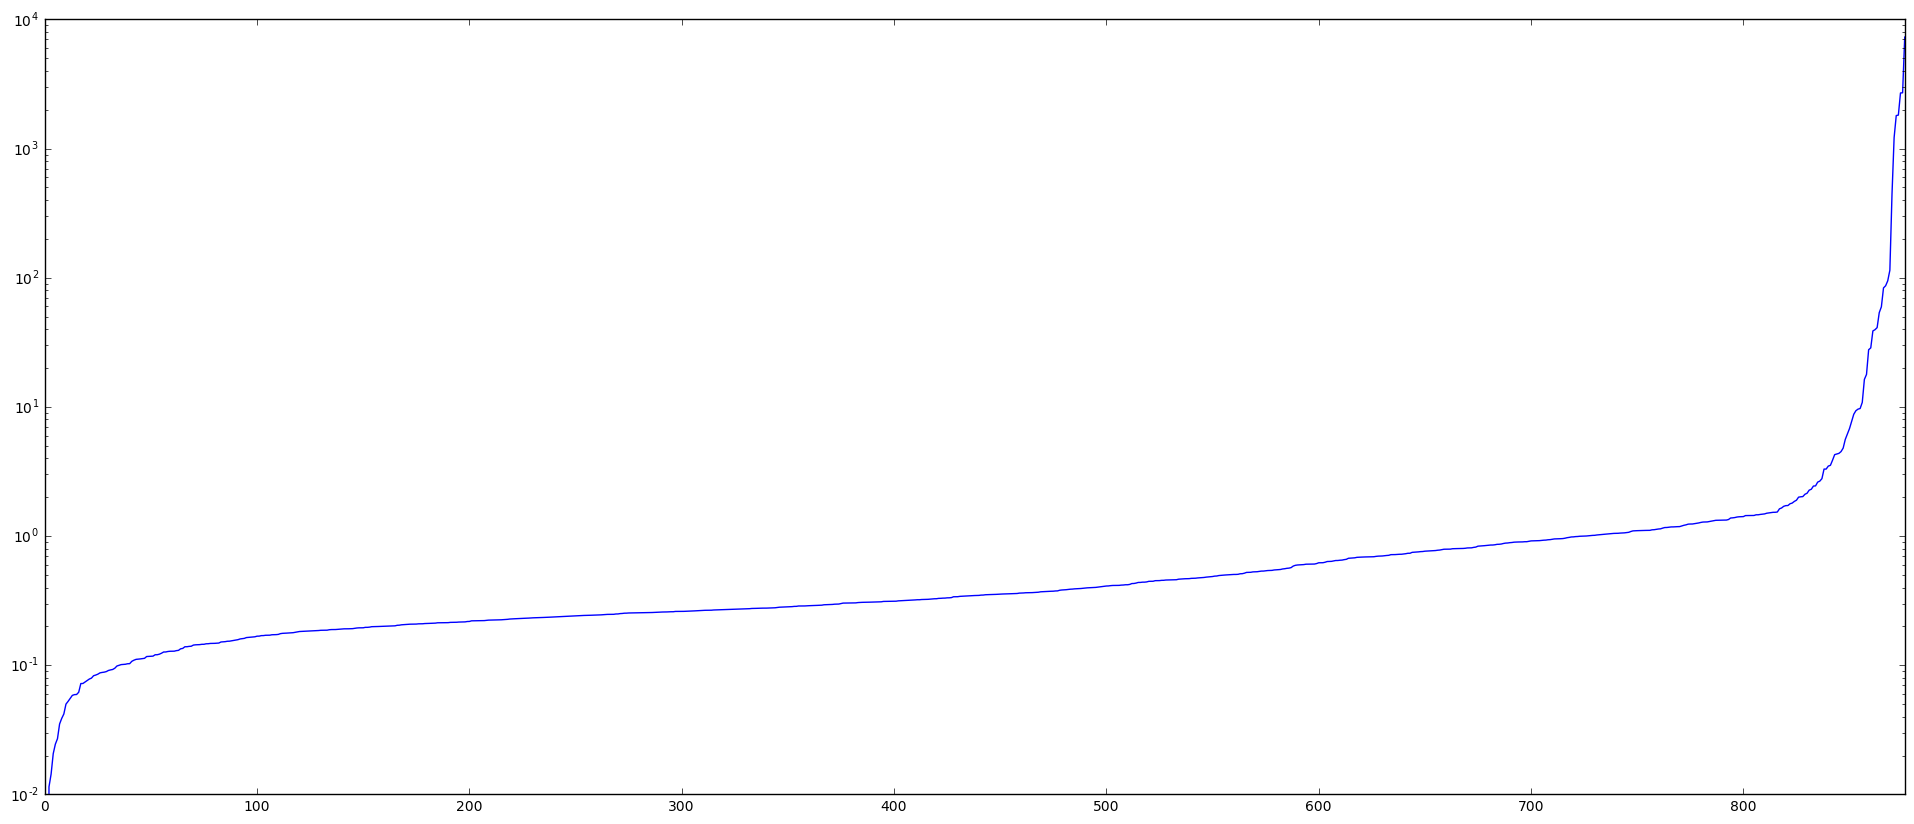

In [33]:
m_ratio.plot(logy=True, figsize=(24, 10))

What percentage of records are accurate to within plus/minus 25%?

In [34]:
len(m_ratio[(m_ratio > 0.75) & (m_ratio < 1.25)]) / len(m_ratio)

0.1516533637400228

Here's a plot of market value versus predicted value ranked by market value:

A little more information about our dataset before we select a band: is under to over -estimation somehow correlated with actual market value, as I assume is the case (it's easier to be wrong about a big building than a small one)?

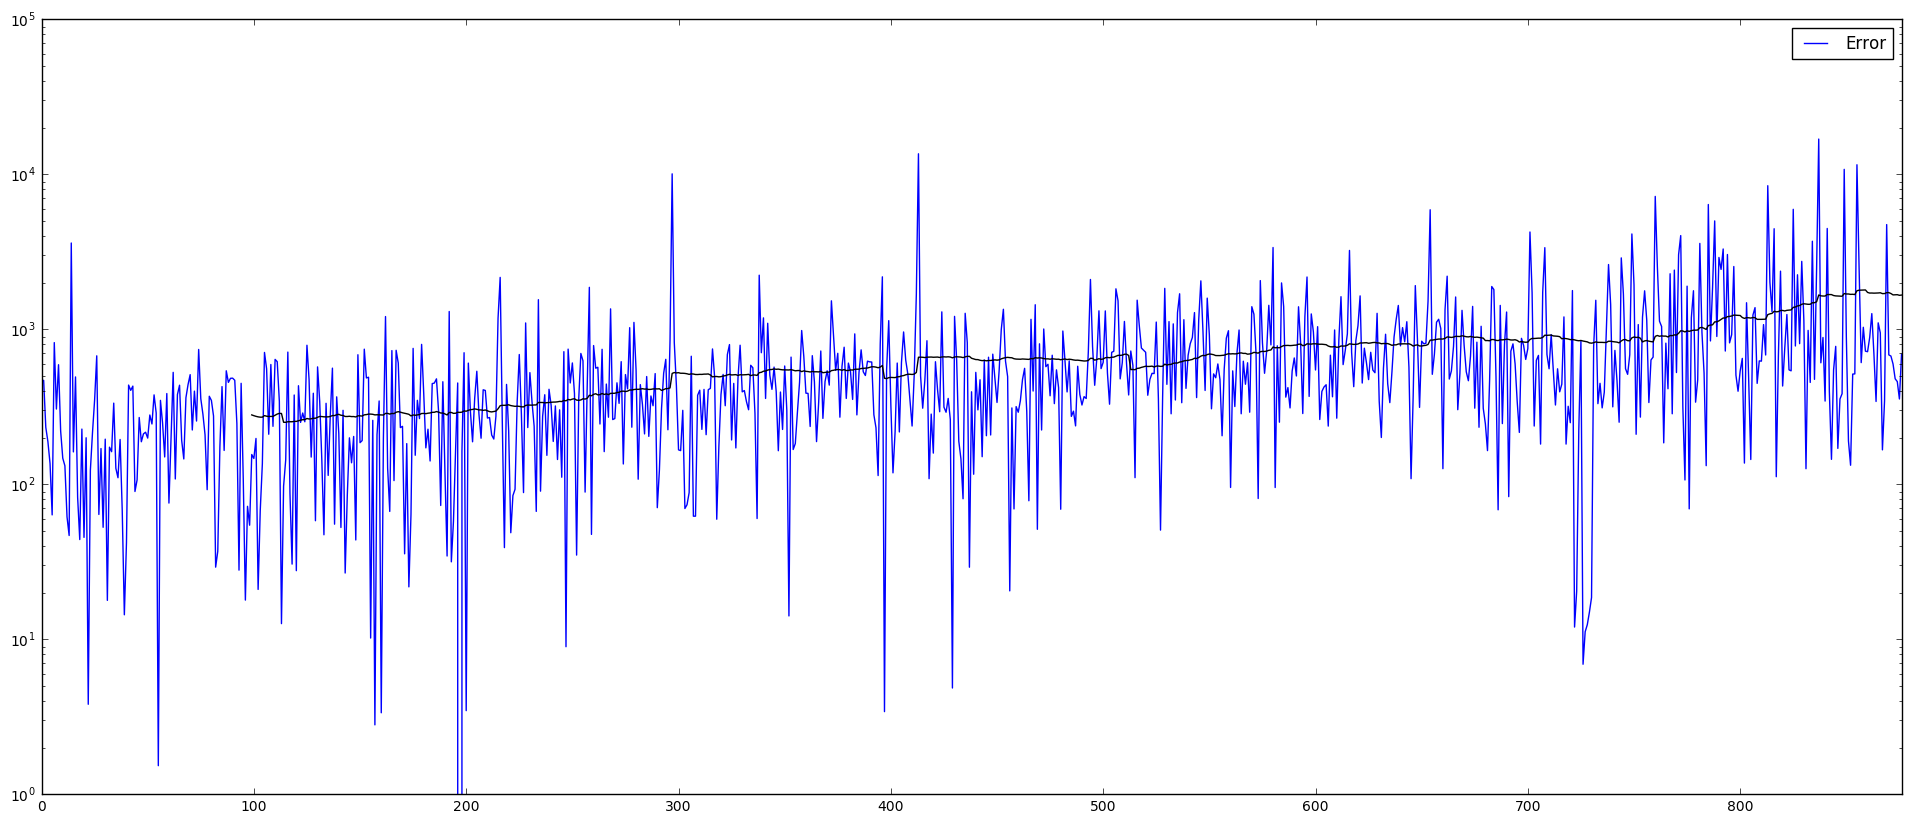

In [35]:
train_set_s = train_set.copy()
train_set_s['ValueRatio'] = train_set['EstCurentMarketValueSqFt'] / train_set['MarketValueSqFt']
train_set_s['Error'] = np.abs(train_set['EstCurentMarketValueSqFt'] - train_set['MarketValueSqFt'])
axes = train_set_s.sort_values(by='SalePrice').reset_index().plot(figsize=(24, 10), y='Error', logy=True, color='b')
rolling = train_set_s.sort_values(by='SalePrice').reset_index()['Error'].rolling(center=False, window=100).mean()
rolling.plot(ax=axes, color='black')

This plot shows the absolute difference between expected and actual market value per square foot.

As expected, the city's model does best when predicting intermediate varibles, and low and high values cause the error to rise. 

There are two sources of strong systemic error in the city's model. The first is error on the lowest-value sales, which, as previously discussed, come about as a result of non-market sales. The second is error on the highest-value sales, which comes from the model performing very poorly when attempting to price skyscrapers.

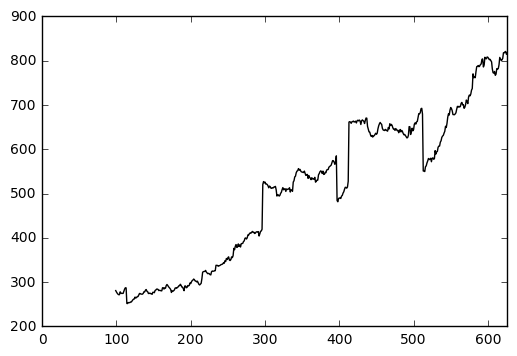

In [36]:
rolling[:-250].plot(color='black')

Looking at a wrongness ratio:

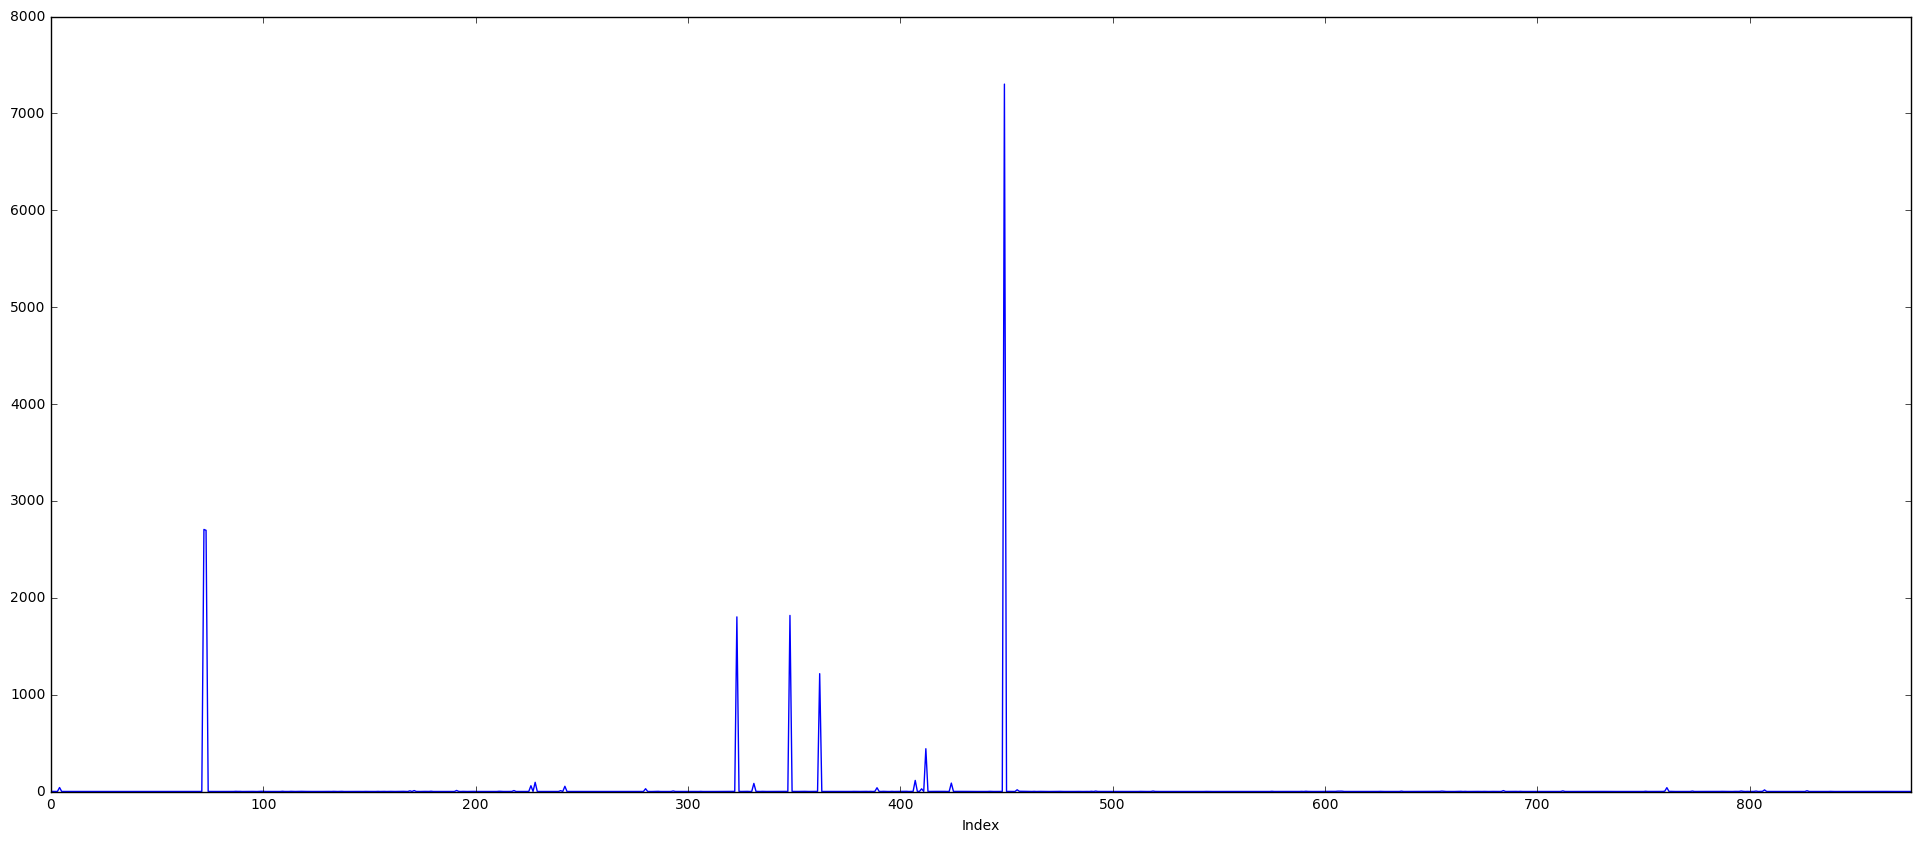

In [37]:
(train_set_s['ValueRatio']).plot(figsize=(24, 10))

This doesn't make picking a good cutoff easier; mostly it just shows that there are some really extreme outliers out there. At what point do we stop losing missinformation and start losing the real thing? One more look to decide...

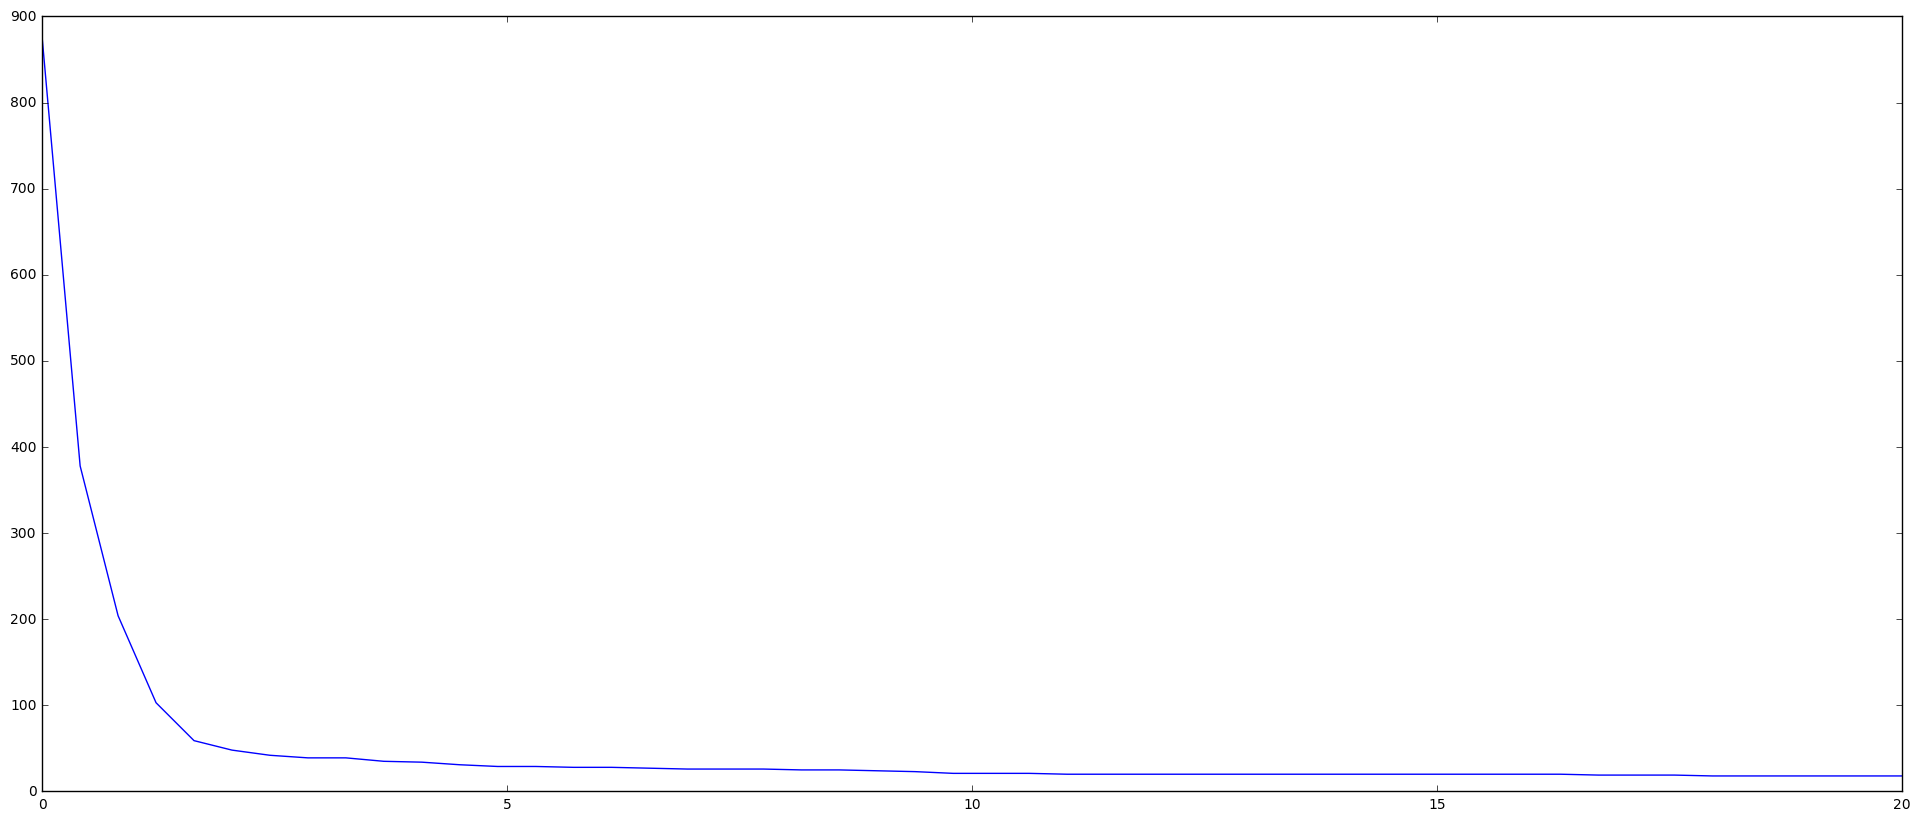

In [38]:
pd.Series({n: len(train_set_s[train_set_s['ValueRatio'] > n]) for n in np.linspace(0, 20)}).plot(figsize=(24, 10))

In [39]:
train_set_s['OffRatio'] =  ((np.abs(train_set_s['EstCurentMarketValueSqFt'] - train_set_s['MarketValueSqFt'])) / train_set_s['MarketValueSqFt'])

I decided to be very conservative and band at no more than two standard deviations/the 1% percentile of the data&mdash;corresponding with a cutoff of `'OffRatio' = 10`.

In [40]:
len(train_set_s[train_set_s['ValueRatio'] > 10]) / len(train_set_s)

0.02394526795895097

In [41]:
train_set_ss = train_set_s[train_set_s['ValueRatio'] < 10]

Looking at the plot again afterwards:

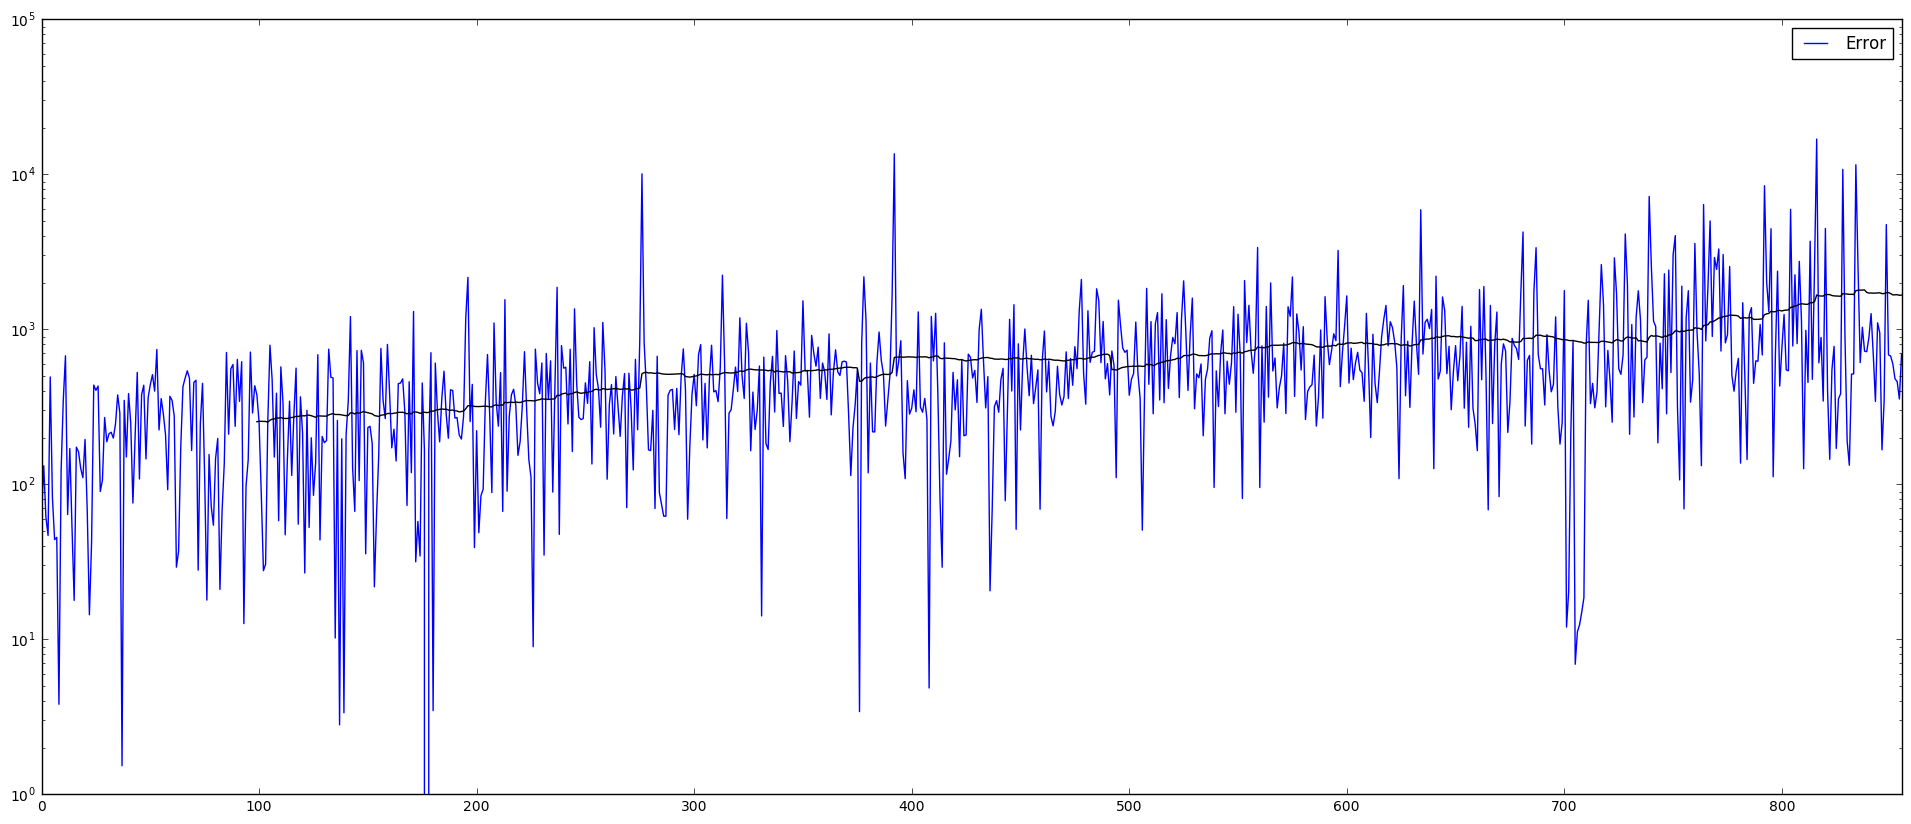

In [42]:
axes_2 = train_set_ss.sort_values(by='SalePrice').reset_index().plot(figsize=(24, 10), y='Error', logy=True, color='b')
rolling_2 = train_set_ss.sort_values(by='SalePrice').reset_index()['Error'].rolling(center=False, window=100).mean()
rolling_2.plot(ax=axes_2, color='black')

Not much changes! And that's a good thing; of course that's because we only dropped 1% of the total data.

We may filter again later into the process.

Now all that remains is deleting our temporary columns and saving the data.

In [43]:
train_set_sss = train_set_ss[train_set.columns]

# In progress
There are still some issues with the data that I would like to handle.

In [44]:
r_p=train_set_sss

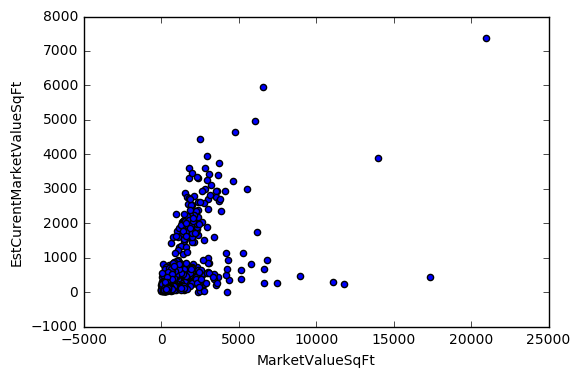

In [45]:
r_p[['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(x='MarketValueSqFt', y='EstCurentMarketValueSqFt', kind='scatter')

There are few outliers.

(0, 5000)

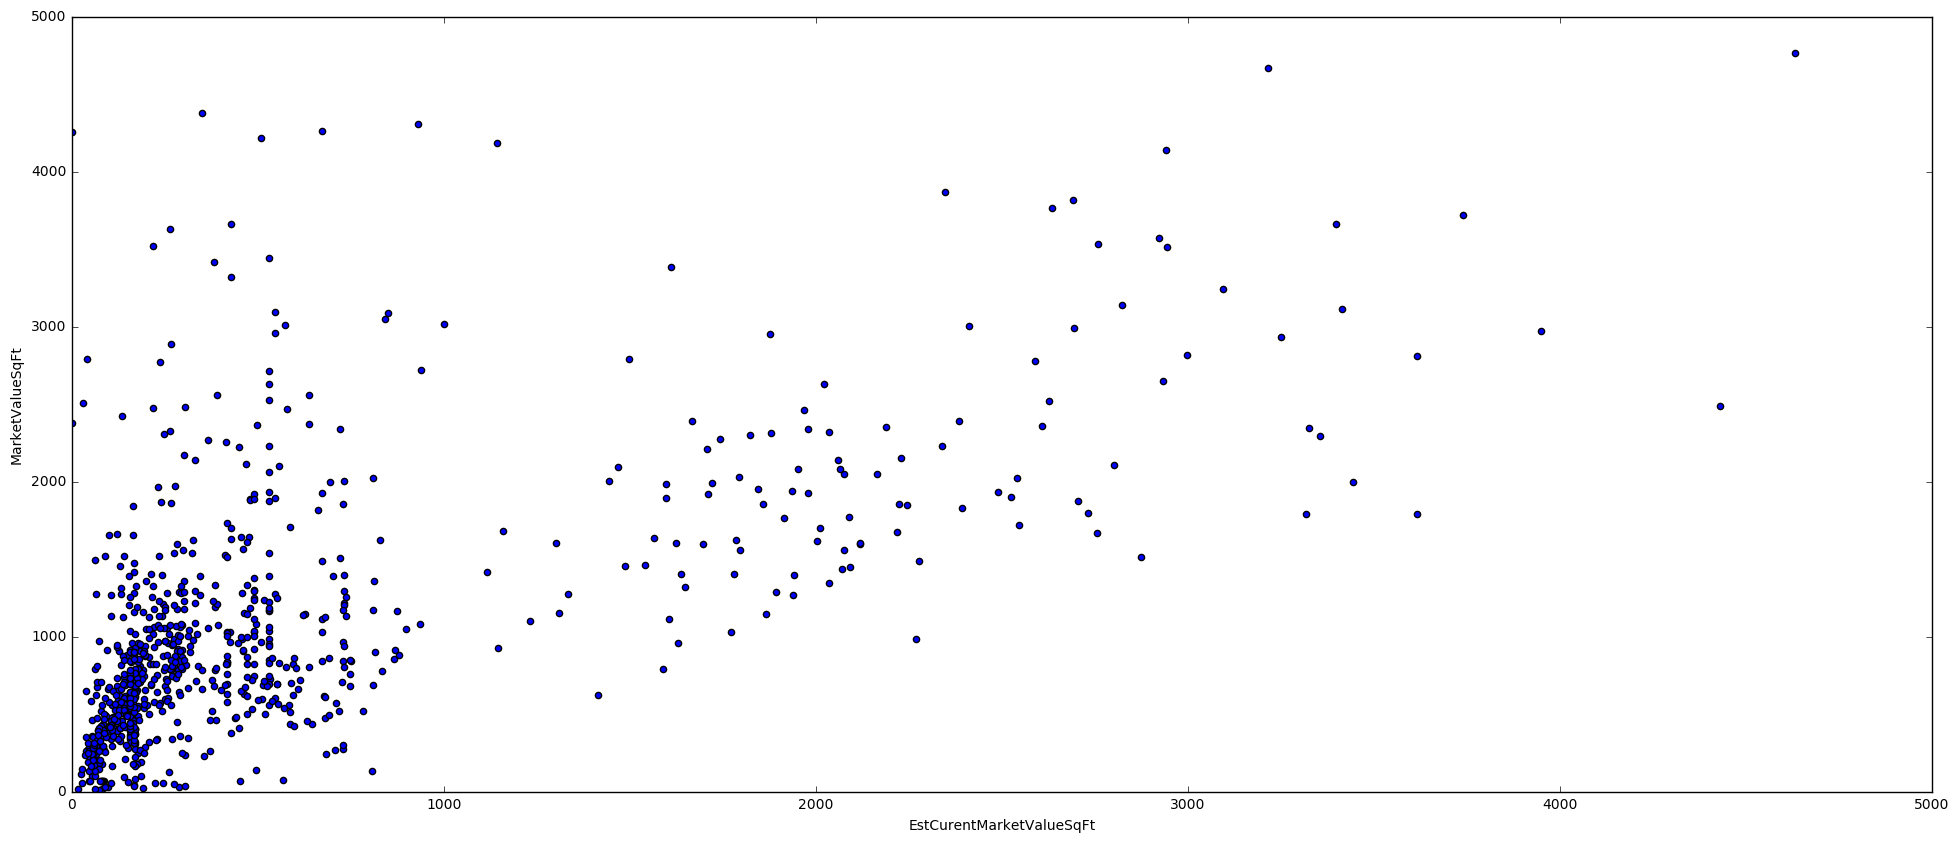

In [46]:
ax = r_p[r_p['MarketValueSqFt'] < 10000][['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                                                               x='EstCurentMarketValueSqFt',
                                                                                               kind='scatter',
                                                                                               figsize=(24, 10))
ax.set_xlim([0,5000])
ax.set_ylim([0,5000])

The [most expensive real estate in Manhattan](http://www.businessinsider.com/inside-one57-most-expensive-building-2015-11) costs ~$6000 per square foot at its peak, so entries over that value are 100% data definition errors in the RPAD file (adding an extra 0 perhaps).

In [47]:
r_p = r_p[r_p['MarketValueSqFt'] < 6000]
r_p = r_p[r_p['EstCurentMarketValueSqFt'] < 6000] # Removes but two values.

There was a sufficiently large number of cases in which estimated market value was out of band with the actual sale market value for it to be suspect.
If the plot was a construction zone or an empty lot at the time that it was assessed for RPAD, the land will obviously carry little value. Yet it can suddenly become very valuable once a building is constructed there, goes onto the market, and gets sold. 

There are number of cases in which the RPAD assessments are based on an empty or unconstructed lot, and the actual market sale is going to be based on the value of the building that took its place.

In [48]:
r_p['ValueRatio'] = r_p['MarketValueSqFt'] / r_p['EstCurentMarketValueSqFt']

In [49]:
r_p = r_p[r_p['ValueRatio'] < 10]

(0, 5000)

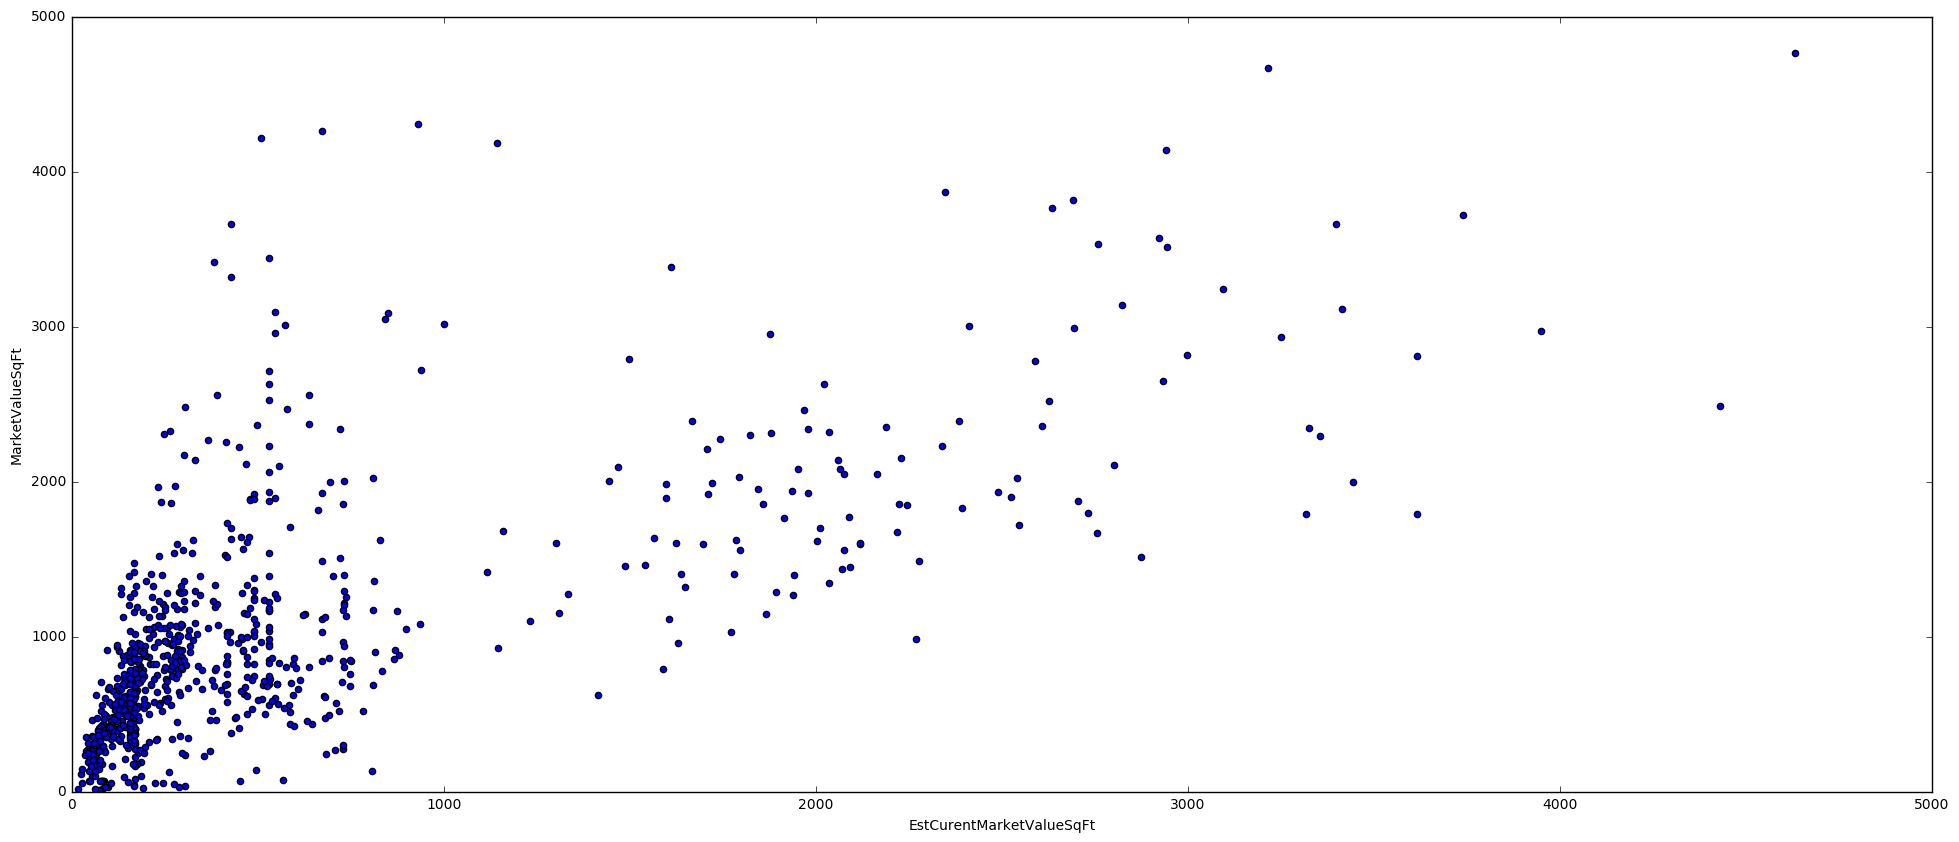

In [50]:
ax = r_p[(r_p['ValueRatio'] < 10)][['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                                                               x='EstCurentMarketValueSqFt',
                                                                                               kind='scatter',
                                                                                               figsize=(24, 10))
ax.set_xlim([0,5000])
ax.set_ylim([0,5000])

We can zoom in on the densest part of the cloud to see local distribution. Again notice that understimates are far denser than overestimates.

(0, 800)

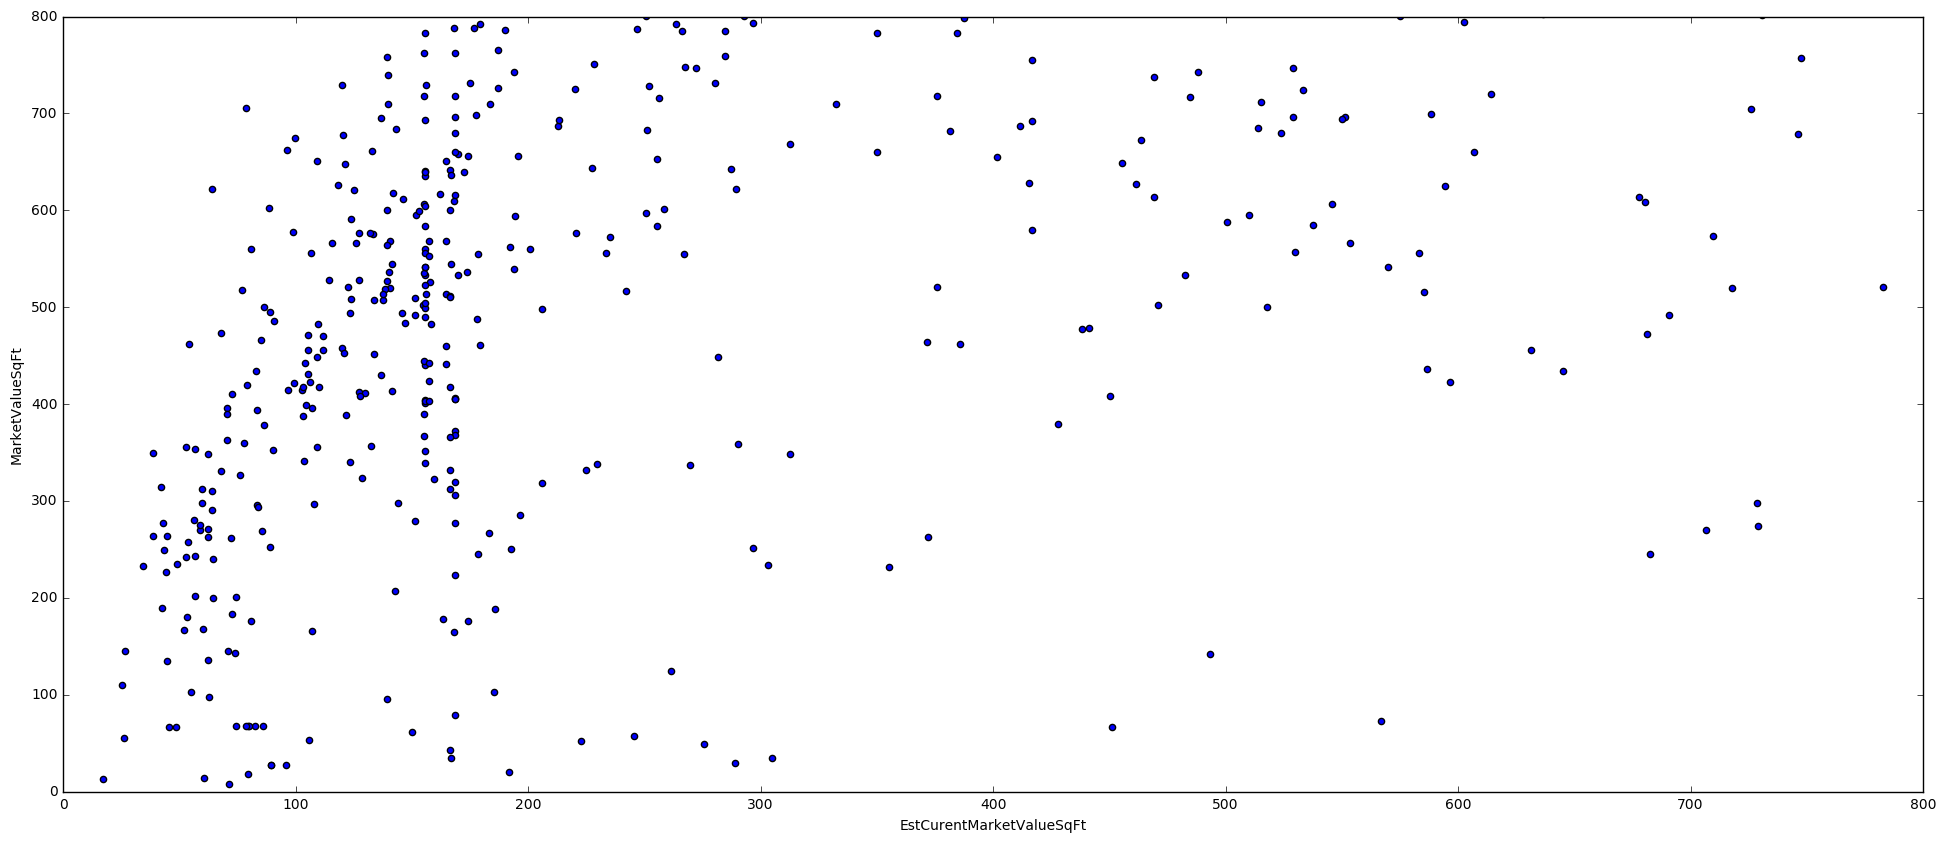

In [51]:
ax = r_p[['MarketValueSqFt', 'EstCurentMarketValueSqFt']].plot(y='MarketValueSqFt',
                                                               x='EstCurentMarketValueSqFt',
                                                               kind='scatter',
                                                               figsize=(24, 10))
ax.set_xlim([0,800])
ax.set_ylim([0,800])

In [52]:
import seaborn as sns

The KDE plot bands the data entirely within a `700x700` box, showing that market_value for most of the properties are in 5-10% variation of estimated_value.

I believe that the unnervingly dense cloud significantly above the x=y line is *mostly* a result of the natural variability and noise of market sales.

[(0, 700), (0, 700)]

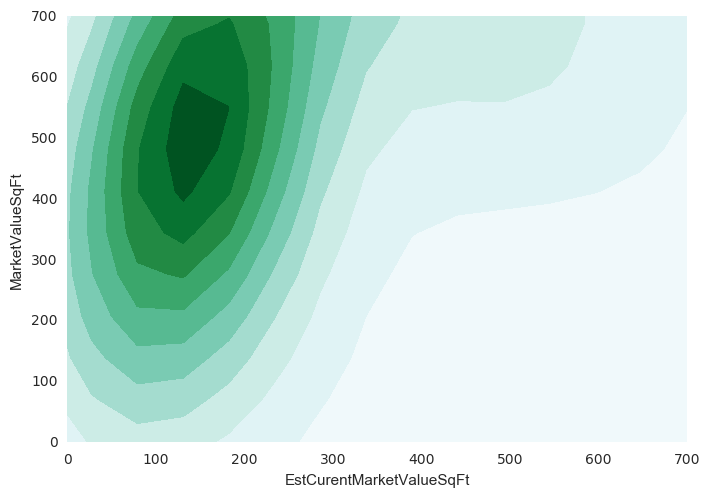

In [53]:
ax = sns.kdeplot(r_p['EstCurentMarketValueSqFt'], r_p['MarketValueSqFt'], shade=True, figsize=(24, 10))
ax.set(xlim=(0, 700), ylim=(0, 700))

In [54]:
r_p.to_csv('nyc_building_sales.csv')